# Few-Shot Anomaly Detection using DINOv3
This notebook implements a full pipeline for few-shot anomaly detection using DINO features in an object-oriented way. It covers preprocessing, feature extraction, feature bank creation, scoring, and evaluation.

## 1. Imports and Setup
Imports all required libraries and sets up the device (CPU or GPU).

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional, Dict
import faiss
from dataclasses import dataclass
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. ImagePreprocessor Class
Handles image loading, resizing, normalization, and batching for DINO input.

In [ ]:
class ImagePreprocessor:
    def __init__(self, input_size: int = 224, batch_size: int = 32):
        self.input_size = input_size
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(int(input_size * 1.14)),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    def load_image(self, image_path: str) -> Image.Image:
        if isinstance(image_path, str):
            return Image.open(image_path).convert('RGB')
        return image_path
    def preprocess_single(self, image: Image.Image) -> torch.Tensor:
        return self.transform(image).unsqueeze(0)
    def preprocess_batch(self, images: List[Image.Image]) -> torch.Tensor:
        tensors = [self.transform(img) for img in images]
        return torch.stack(tensors)
    def load_images_from_directory(self, directory: str, extensions: Tuple[str, ...] = ('.png', '.jpg', '.jpeg')) -> List[str]:
        directory_path = Path(directory)
        image_paths = []
        for ext in extensions:
            image_paths.extend(directory_path.glob(f"*{ext}"))
        return sorted([str(p) for p in image_paths])
    def create_batches(self, image_paths: List[str]) -> List[Tuple[torch.Tensor, List[str]]]:
        batches = []
        for i in range(0, len(image_paths), self.batch_size):
            batch_paths = image_paths[i:i + self.batch_size]
            batch_images = [self.load_image(path) for path in batch_paths]
            batch_tensor = self.preprocess_batch(batch_images)
            batches.append((batch_tensor, batch_paths))
        return batches
print("✓ ImagePreprocessor class defined")

✓ ImagePreprocessor class defined


## 3. FeatureExtractor Class
Extracts patch-level features from DINOv3 models, handling both tensor and dict outputs. L2-normalizes features if specified.

In [ ]:
class FeatureExtractor:
    def __init__(self, model, device: torch.device, l2_normalize: bool = True):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
        self.l2_normalize = l2_normalize
        self.patch_size = 16
    @torch.no_grad()
    def extract_features(self, images: torch.Tensor, return_cls: bool = False) -> torch.Tensor:
        images = images.to(self.device)
        if hasattr(self.model, 'forward_features'):
            features = self.model.forward_features(images)
            if isinstance(features, dict):
                if 'x_norm_patchtokens' in features:
                    patch_features = features['x_norm_patchtokens']
                    cls_features = features.get('x_norm_clstoken', None)
                elif 'x_prenorm' in features:
                    all_tokens = features['x_prenorm']
                    cls_features = all_tokens[:, 0, :]
                    patch_features = all_tokens[:, 1:, :]
                else:
                    raise ValueError(f"Unexpected dict keys: {features.keys()}")
            else:
                if len(features.shape) == 3:
                    cls_features = features[:, 0, :]
                    patch_features = features[:, 1:, :]
                elif len(features.shape) == 2:
                    features = self.model.get_intermediate_layers(images, n=1, return_class_token=True)
                    if isinstance(features, (list, tuple)):
                        features = features[0]
                    cls_features = features[0] if isinstance(features, (list, tuple)) else features[:, 0, :]
                    patch_features = features[1] if isinstance(features, (list, tuple)) else features[:, 1:, :]
                else:
                    raise ValueError(f"Unexpected feature shape: {features.shape}")
        else:
            features = self.model(images)
            if isinstance(features, dict):
                if 'x_norm_patchtokens' in features:
                    patch_features = features['x_norm_patchtokens']
                    cls_features = features.get('x_norm_clstoken', None)
                else:
                    raise ValueError(f"Cannot extract patches from dict: {features.keys()}")
            elif len(features.shape) == 2:
                patch_features = self.model.get_intermediate_layers(images, n=1, return_class_token=False)[0]
                cls_features = features
            else:
                cls_features = features[:, 0, :]
                patch_features = features[:, 1:, :]
        if self.l2_normalize:
            patch_features = F.normalize(patch_features, p=2, dim=-1)
            if return_cls and cls_features is not None:
                cls_features = F.normalize(cls_features, p=2, dim=-1)
        if return_cls:
            return patch_features, cls_features
        return patch_features
    def get_feature_dim(self) -> int:
        if hasattr(self.model, 'embed_dim'):
            return self.model.embed_dim
        elif hasattr(self.model, 'num_features'):
            return self.model.num_features
        elif hasattr(self.model, 'backbone'):
            if hasattr(self.model.backbone, 'embed_dim'):
                return self.model.backbone.embed_dim
        return 384
    def get_patch_grid_size(self, input_size: int = 224) -> Tuple[int, int]:
        grid_h = grid_w = input_size // self.patch_size
        return (grid_h, grid_w)
    def extract_from_multiple_batches(self, batches: List[Tuple[torch.Tensor, List[str]]]) -> Dict[str, np.ndarray]:
        feature_dict = {}
        for batch_tensor, batch_paths in tqdm(batches, desc="Extracting features"):
            patch_features = self.extract_features(batch_tensor)
            patch_features_np = patch_features.cpu().numpy()
            for i, path in enumerate(batch_paths):
                feature_dict[path] = patch_features_np[i]
        return feature_dict
print("✓ FeatureExtractor class defined")

✓ FeatureExtractor class defined


## 4. NormalFeatureBank Class
Stores and indexes normal image features using FAISS for fast k-NN search and computes Mahalanobis statistics. If you want to use GPU acceleration for FAISS, set `use_gpu_faiss=True` and ensure you have `faiss-gpu` installed.

In [ ]:
class NormalFeatureBank:
    def __init__(self, feature_dim: int, use_gpu: bool = True, index_type: str = 'flat'):
        self.feature_dim = feature_dim
        self.index_type = index_type
        self.use_gpu = use_gpu and torch.cuda.is_available() and hasattr(faiss, 'StandardGpuResources')
        if use_gpu and not self.use_gpu:
            print("Warning: GPU FAISS requested but not available. Using CPU version.")
            print("To use GPU FAISS, install with: pip uninstall faiss-cpu && pip install faiss-gpu")
        self.index = self._create_index()
        self.mean = None
        self.cov_inv = None
        self.features_array = None
    def _create_index(self) -> faiss.Index:
        if self.index_type == 'flat':
            index = faiss.IndexFlatL2(self.feature_dim)
        elif self.index_type == 'ivf':
            quantizer = faiss.IndexFlatL2(self.feature_dim)
            index = faiss.IndexIVFFlat(quantizer, self.feature_dim, 100)
        else:
            raise ValueError(f"Unknown index type: {self.index_type}")
        if self.use_gpu:
            try:
                res = faiss.StandardGpuResources()
                index = faiss.index_cpu_to_gpu(res, 0, index)
                print("✓ Using GPU for FAISS index")
            except Exception as e:
                print(f"Warning: Failed to move index to GPU: {e}")
                print("Continuing with CPU index")
                self.use_gpu = False
        else:
            print("✓ Using CPU for FAISS index")
        return index
    def build_from_features(self, feature_dict: Dict[str, np.ndarray], compute_statistics: bool = True):
        all_features = []
        for features in feature_dict.values():
            all_features.append(features)
        self.features_array = np.vstack(all_features).astype('float32')
        print(f"Building index with {self.features_array.shape[0]} patch features...")
        if self.index_type == 'ivf' and not self.index.is_trained:
            self.index.train(self.features_array)
        self.index.add(self.features_array)
        if compute_statistics:
            self._compute_statistics()
        print(f"✓ Feature bank built with {self.index.ntotal} features")
    def _compute_statistics(self):
        print("Computing Mahalanobis statistics...")
        self.mean = np.mean(self.features_array, axis=0)
        centered = self.features_array - self.mean
        cov = np.cov(centered.T)
        reg = 1e-5
        cov = cov + reg * np.eye(self.feature_dim)
        try:
            self.cov_inv = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            print("Warning: Covariance matrix is singular, using pseudo-inverse")
            self.cov_inv = np.linalg.pinv(cov)
        print("✓ Statistics computed")
    def search_knn(self, query_features: np.ndarray, k: int = 1) -> Tuple[np.ndarray, np.ndarray]:
        query_features = query_features.astype('float32')
        distances, indices = self.index.search(query_features, k)
        return distances, indices
    def compute_mahalanobis_distance(self, query_features: np.ndarray) -> np.ndarray:
        if self.mean is None or self.cov_inv is None:
            raise ValueError("Statistics not computed. Set compute_statistics=True when building.")
        centered = query_features - self.mean
        mahal = np.sum(centered @ self.cov_inv * centered, axis=1)
        return np.sqrt(mahal)
    def save(self, path: str):
        save_dict = {
            'features_array': self.features_array,
            'mean': self.mean,
            'cov_inv': self.cov_inv,
            'feature_dim': self.feature_dim,
            'index_type': self.index_type
        }
        index_path = path + '.index'
        if self.use_gpu:
            try:
                cpu_index = faiss.index_gpu_to_cpu(self.index)
                faiss.write_index(cpu_index, index_path)
            except:
                print("Warning: Could not convert GPU index to CPU. Saving as-is.")
                faiss.write_index(self.index, index_path)
        else:
            faiss.write_index(self.index, index_path)
        np.savez(path + '.npz', **save_dict)
        print(f"✓ Feature bank saved to {path}")
    def load(self, path: str):
        data = np.load(path + '.npz', allow_pickle=True)
        self.features_array = data['features_array']
        self.mean = data['mean']
        self.cov_inv = data['cov_inv']
        self.feature_dim = int(data['feature_dim'])
        self.index_type = str(data['index_type'])
        index_path = path + '.index'
        self.index = faiss.read_index(index_path)
        if self.use_gpu:
            try:
                res = faiss.StandardGpuResources()
                self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
            except Exception as e:
                print(f"Warning: Could not move loaded index to GPU: {e}")
                self.use_gpu = False
        print(f"✓ Feature bank loaded from {path}")
print("✓ NormalFeatureBank class defined")

✓ NormalFeatureBank class defined


## 5. AnomalyScorer Class
Computes patch-level and image-level anomaly scores using k-NN or Mahalanobis distance. Also provides visualization.

In [ ]:
@dataclass
class AnomalyResult:
    image_score: float
    patch_scores: np.ndarray
    anomaly_map: np.ndarray
    is_anomaly: bool
    method: str
class AnomalyScorer:
    def __init__(self, feature_bank: NormalFeatureBank, patch_grid_size: Tuple[int, int], method: str = 'knn', k: int = 1, threshold: Optional[float] = None):
        self.feature_bank = feature_bank
        self.patch_grid_size = patch_grid_size
        self.method = method
        self.k = k
        self.threshold = threshold
    def compute_patch_scores(self, patch_features: np.ndarray) -> np.ndarray:
        if self.method == 'knn':
            distances, _ = self.feature_bank.search_knn(patch_features, k=self.k)
            scores = np.mean(distances, axis=1)
        elif self.method == 'mahalanobis':
            scores = self.feature_bank.compute_mahalanobis_distance(patch_features)
        else:
            raise ValueError(f"Unknown method: {self.method}")
        return scores
    def create_anomaly_map(self, patch_scores: np.ndarray, target_size: Tuple[int, int] = (224, 224)) -> np.ndarray:
        H, W = self.patch_grid_size
        score_map = patch_scores.reshape(H, W)
        anomaly_map = cv2.resize(score_map, target_size, interpolation=cv2.INTER_CUBIC)
        return anomaly_map
    def compute_image_score(self, patch_scores: np.ndarray, aggregation: str = 'max') -> float:
        if aggregation == 'max':
            return float(np.max(patch_scores))
        elif aggregation == 'mean':
            return float(np.mean(patch_scores))
        elif aggregation == 'percentile_95':
            return float(np.percentile(patch_scores, 95))
        else:
            raise ValueError(f"Unknown aggregation: {aggregation}")
    def score_image(self, patch_features: np.ndarray, target_size: Tuple[int, int] = (224, 224), aggregation: str = 'max') -> AnomalyResult:
        patch_scores = self.compute_patch_scores(patch_features)
        image_score = self.compute_image_score(patch_scores, aggregation)
        anomaly_map = self.create_anomaly_map(patch_scores, target_size)
        is_anomaly = False
        if self.threshold is not None:
            is_anomaly = image_score > self.threshold
        return AnomalyResult(image_score=image_score, patch_scores=patch_scores, anomaly_map=anomaly_map, is_anomaly=is_anomaly, method=self.method)
    def set_threshold_from_normal_scores(self, normal_image_scores: List[float], percentile: float = 99.0):
        self.threshold = np.percentile(normal_image_scores, percentile)
        print(f"✓ Threshold set to {self.threshold:.4f} ({percentile}th percentile)")
    def visualize_result(self, image: Image.Image, result: AnomalyResult, figsize: Tuple[int, int] = (15, 5)):
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        im = axes[1].imshow(result.anomaly_map, cmap='jet')
        axes[1].set_title(f"Anomaly Map ({result.method})")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1])
        axes[2].imshow(image)
        axes[2].imshow(result.anomaly_map, cmap='jet', alpha=0.5)
        status = "ANOMALY" if result.is_anomaly else "NORMAL"
        axes[2].set_title(f"Overlay - Score: {result.image_score:.4f} [{status}]")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
print("✓ AnomalyScorer class defined")

✓ AnomalyScorer class defined


## 6. ZeroShotAnomalyDetector Class
Main orchestrator that integrates all components for end-to-end anomaly detection. Adjust parameters such as `input_size`, `batch_size`, `l2_normalize`, `use_gpu_faiss`, `index_type`, `scoring_method`, and `k` as needed for your use case.

In [ ]:
class ZeroShotAnomalyDetector:
    def __init__(self, 
                 model,
                 input_size: int = 224,
                 batch_size: int = 32,
                 device: torch.device = None,
                 l2_normalize: bool = True,
                 use_gpu_faiss: bool = True,
                 index_type: str = 'flat',
                 scoring_method: str = 'knn',
                 k: int = 1):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.preprocessor = ImagePreprocessor(input_size=input_size, batch_size=batch_size)
        self.feature_extractor = FeatureExtractor(model, device=self.device, l2_normalize=l2_normalize)
        self.input_size = input_size
        self.scoring_method = scoring_method
        self.k = k
        self.use_gpu_faiss = use_gpu_faiss
        self.index_type = index_type
        self.feature_bank = None
        self.scorer = None
        print(f"✓ ZeroShotAnomalyDetector initialized on {self.device}")
    def fit(self, normal_images_dir: str, compute_mahalanobis: bool = True):
        print(f"\n{'='*60}")
        print("TRAINING: Building normal feature bank")
        print(f"{'='*60}")
        image_paths = self.preprocessor.load_images_from_directory(normal_images_dir)
        print(f"Found {len(image_paths)} normal images")
        batches = self.preprocessor.create_batches(image_paths)
        print(f"Created {len(batches)} batches")
        feature_dict = self.feature_extractor.extract_from_multiple_batches(batches)
        feature_dim = self.feature_extractor.get_feature_dim()
        self.feature_bank = NormalFeatureBank(
            feature_dim=feature_dim,
            use_gpu=self.use_gpu_faiss,
            index_type=self.index_type
        )
        compute_stats = compute_mahalanobis or (self.scoring_method == 'mahalanobis')
        self.feature_bank.build_from_features(feature_dict, compute_statistics=compute_stats)
        patch_grid_size = self.feature_extractor.get_patch_grid_size(self.input_size)
        self.scorer = AnomalyScorer(
            feature_bank=self.feature_bank,
            patch_grid_size=patch_grid_size,
            method=self.scoring_method,
            k=self.k
        )
        print(f"\n✓ Training complete!")
        return self
    def set_threshold(self, validation_images_dir: str, percentile: float = 99.0):
        if self.scorer is None:
            raise ValueError("Detector not trained. Call fit() first.")
        print(f"\n{'='*60}")
        print("CALIBRATION: Setting threshold from validation set")
        print(f"{'='*60}")
        validation_scores = []
        image_paths = self.preprocessor.load_images_from_directory(validation_images_dir)
        for img_path in tqdm(image_paths, desc="Scoring validation images"):
            image = self.preprocessor.load_image(img_path)
            result = self.predict(image)
            validation_scores.append(result.image_score)
        self.scorer.set_threshold_from_normal_scores(validation_scores, percentile)
        print(f"Validation score range: [{min(validation_scores):.4f}, {max(validation_scores):.4f}]")
        print(f"Mean: {np.mean(validation_scores):.4f}, Std: {np.std(validation_scores):.4f}")
        return self
    def predict(self, image: Image.Image) -> AnomalyResult:
        if self.scorer is None:
            raise ValueError("Detector not trained. Call fit() first.")
        image_tensor = self.preprocessor.preprocess_single(image)
        patch_features = self.feature_extractor.extract_features(image_tensor)  # (1, num_patches, D)
        patch_features = patch_features[0].cpu().numpy()  # (num_patches, D)
        result = self.scorer.score_image(
            patch_features,
            target_size=(self.input_size, self.input_size)
        )
        return result
    def predict_from_path(self, image_path: str) -> AnomalyResult:
        image = self.preprocessor.load_image(image_path)
        return self.predict(image)
    def predict_batch(self, images: List[Image.Image]) -> List[AnomalyResult]:
        return [self.predict(img) for img in images]
    def evaluate(self, test_images_dir: str, show_samples: int = 5) -> Dict:
        if self.scorer is None:
            raise ValueError("Detector not trained. Call fit() first.")
        image_paths = self.preprocessor.load_images_from_directory(test_images_dir)
        print(f"Found {len(image_paths)} test images")
        results = []
        for img_path in tqdm(image_paths, desc="Testing images"):
            image = self.preprocessor.load_image(img_path)
            result = self.predict(image)
            results.append((img_path, image, result))
        scores = [r[2].image_score for r in results]
        anomalies = [r[2].is_anomaly for r in results]
        metrics = {
            'num_images': len(results),
            'num_anomalies': sum(anomalies),
            'anomaly_rate': sum(anomalies) / len(anomalies) if anomalies else 0,
            'score_mean': np.mean(scores),
            'score_std': np.std(scores),
            'score_min': np.min(scores),
            'score_max': np.max(scores)
        }
        print(f"\nTest Results:")
        print(f"  Total images: {metrics['num_images']}")
        print(f"  Detected anomalies: {metrics['num_anomalies']} ({metrics['anomaly_rate']*100:.1f}%)")
        print(f"  Score range: [{metrics['score_min']:.4f}, {metrics['score_max']:.4f}]")
        print(f"  Score mean ± std: {metrics['score_mean']:.4f} ± {metrics['score_std']:.4f}")
        if show_samples > 0:
            print(f"\nShowing {show_samples} sample results...")
            for i, (path, image, result) in enumerate(results[:show_samples]):
                print(f"\nSample {i+1}: {Path(path).name}")
                self.scorer.visualize_result(image, result)
        return metrics
    def save(self, path: str):
        if self.feature_bank is None:
            raise ValueError("Detector not trained. Call fit() first.")
        self.feature_bank.save(path + '_bank')
        config = {
            'input_size': self.input_size,
            'scoring_method': self.scoring_method,
            'k': self.k,
            'threshold': self.scorer.threshold if self.scorer else None,
            'patch_grid_size': self.scorer.patch_grid_size if self.scorer else None
        }
        np.savez(path + '_config.npz', **config)
        print(f"✓ Detector saved to {path}")
    def load(self, path: str):
        feature_dim = self.feature_extractor.get_feature_dim()
        self.feature_bank = NormalFeatureBank(
            feature_dim=feature_dim,
            use_gpu=self.use_gpu_faiss,
            index_type=self.index_type
        )
        self.feature_bank.load(path + '_bank')
        config = np.load(path + '_config.npz', allow_pickle=True)
        self.input_size = int(config['input_size'])
        self.scoring_method = str(config['scoring_method'])
        self.k = int(config['k'])
        threshold = config['threshold'].item()
        patch_grid_size = tuple(config['patch_grid_size'])
        self.scorer = AnomalyScorer(
            feature_bank=self.feature_bank,
            patch_grid_size=patch_grid_size,
            method=self.scoring_method,
            k=self.k,
            threshold=threshold
        )
        print(f"✓ Detector loaded from {path}")
print("✓ ZeroShotAnomalyDetector class defined")

✓ ZeroShotAnomalyDetector class defined



## 7. Usage Example - Load DINO Model
Loads the DINOv3 model from a local repository. Adjust `REPO_DIR` and `WEIGHTS_PATH` to point to your local DINOv3 code and weights.

In [ ]:
# Configuration
REPO_DIR = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\dinov3"
WEIGHTS_PATH = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\dinov3_vits16_pretrain_lvd1689m-08c60483.pth"

# Load DINO model
print("Loading DINO model...")
dinov3_vits16 = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights=WEIGHTS_PATH)
print("✓ Model loaded successfully")

Loading DINO model...
✓ Model loaded successfully
✓ Model loaded successfully


## 8. Initialize Detector and Train on Normal Images
Initializes the anomaly detector and trains it on normal images. Adjust `NORMAL_TRAIN_PATH` to your normal training data. Set `use_gpu_faiss=True` if you have faiss-gpu installed and want GPU acceleration.

In [ ]:
# Data paths
NORMAL_TRAIN_PATH = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\transistor\train\good"

# Initialize detector
detector = ZeroShotAnomalyDetector(
    model=dinov3_vits16,
    input_size=224,
    batch_size=16,
    l2_normalize=True,
    use_gpu_faiss=True,  # Set to True if you have faiss-gpu installed
    index_type='flat',  # Use 'ivf' for large datasets
    scoring_method='knn',  # or 'mahalanobis'
    k=4  # Number of nearest neighbors
)

# Train on normal images
detector.fit(
    normal_images_dir=NORMAL_TRAIN_PATH,
    compute_mahalanobis=True  # Enable if you want to try Mahalanobis later
)

✓ ZeroShotAnomalyDetector initialized on cuda

TRAINING: Building normal feature bank
Found 213 normal images
Created 14 batches
Created 14 batches


Extracting features: 100%|██████████| 14/14 [00:01<00:00,  7.20it/s]



To use GPU FAISS, install with: pip uninstall faiss-cpu && pip install faiss-gpu
✓ Using CPU for FAISS index
Building index with 41748 patch features...
Computing Mahalanobis statistics...
✓ Statistics computed
✓ Feature bank built with 41748 features

✓ Training complete!
✓ Statistics computed
✓ Feature bank built with 41748 features

✓ Training complete!


## 9. Set Threshold (Optional - using validation set)
Set the anomaly threshold using a validation set of normal images. Adjust `VALIDATION_PATH` and `percentile` as needed. Alternatively, set the threshold manually.

In [ ]:
# Option 1: Use a separate validation set (recommended)
VALIDATION_PATH = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\transistor\test\good"
detector.set_threshold(
    validation_images_dir=VALIDATION_PATH,  # Or use separate validation set
    percentile=80.0  # 13% false positive rate
)
print(f"Threshold set to: {detector.scorer.threshold}")

#Option 2: Set threshold manually
#detector.scorer.threshold = 0.1  # Adjust based on your data
#print(f"Manual threshold set to: {detector.scorer.threshold}")


CALIBRATION: Setting threshold from validation set


Scoring validation images: 100%|██████████| 60/60 [00:06<00:00,  8.60it/s]

✓ Threshold set to 0.1221 (80.0th percentile)
Validation score range: [0.0692, 0.2210]
Mean: 0.1071, Std: 0.0262
Threshold set to: 0.12207458615303039


## 10. Test on Single Image
Tests the detector on a single image. Adjust `TEST_IMAGE_PATH` and the filename as needed.

Image Score: 0.1424
Is Anomaly: True
Method: knn


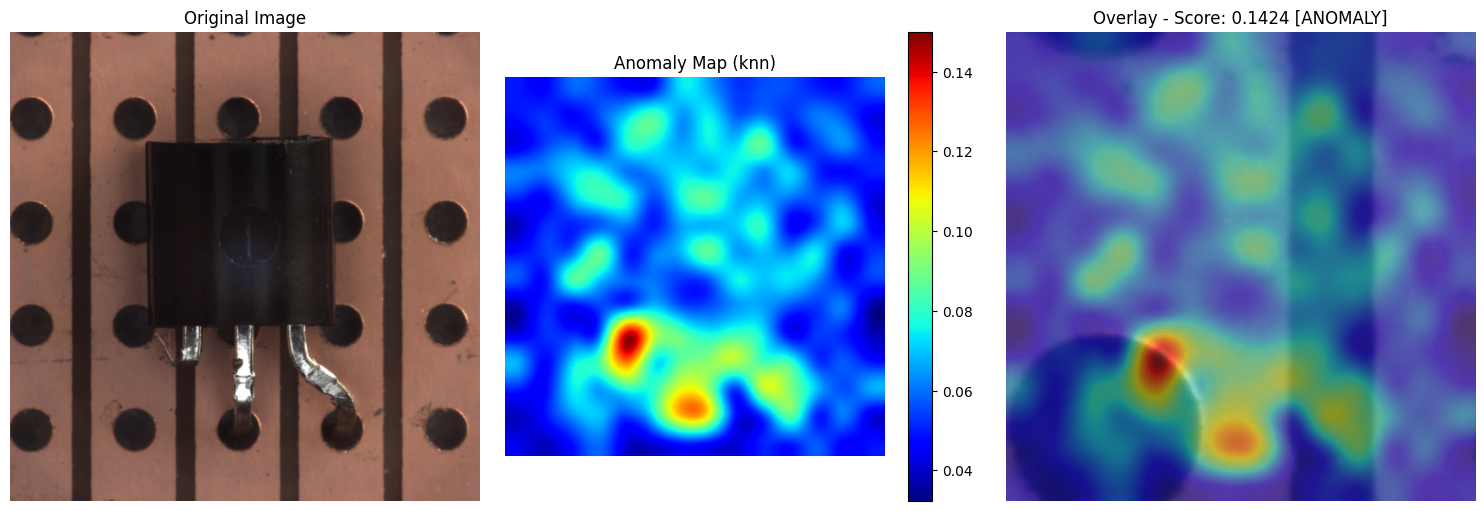

In [ ]:
# Test on a single image
TEST_IMAGE_PATH = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\transistor\test\good"
test_image_path = TEST_IMAGE_PATH + r"\006.png"
test_image = Image.open(test_image_path).convert('RGB')

# Predict
result = detector.predict(test_image)

# Display results
print(f"Image Score: {result.image_score:.4f}")
print(f"Is Anomaly: {result.is_anomaly}")
print(f"Method: {result.method}")

# Visualize
detector.scorer.visualize_result(test_image, result)

## 11. Evaluate on Test Set (if available)
Evaluates the detector on all anomaly types in the test set. Adjust `BASE_TEST_PATH` as needed.

In [ ]:
import os

# Evaluate on multiple anomaly types

# Base test directory
BASE_TEST_PATH = r"C:\Users\berko\OneDrive - Danmarks Tekniske Universitet\DTU\Deep Learning\transistor\test"

# Get all anomaly type folders
anomaly_folders = [f for f in os.listdir(BASE_TEST_PATH) 
                   if os.path.isdir(os.path.join(BASE_TEST_PATH, f))]

print(f"Found {len(anomaly_folders)} anomaly types: {anomaly_folders}\n")

# Evaluate each anomaly type separately
all_results = {}

for anomaly_type in anomaly_folders:
    print(f"\n{'='*60}")
    print(f"Evaluating: {anomaly_type}")
    print(f"{'='*60}") 
    
    anomaly_path = os.path.join(BASE_TEST_PATH, anomaly_type)
    metrics = detector.evaluate(anomaly_path, show_samples=0)  # Set to 0 to disable visualization
    all_results[anomaly_type] = metrics

# Summary statistics
print(f"\n{'='*60}")
print("SUMMARY BY ANOMALY TYPE")
print(f"{'='*60}")
for anomaly_type, metrics in all_results.items():
    print(f"\n{anomaly_type}:")
    print(f"  Images: {metrics['num_images']}")
    print(f"  Detected: {metrics['num_anomalies']} ({metrics['anomaly_rate']*100:.1f}%)")
    print(f"  Score: {metrics['score_mean']:.4f} ± {metrics['score_std']:.4f}")

Found 5 anomaly types: ['bent_lead', 'cut_lead', 'damaged_case', 'good', 'misplaced']


Evaluating: bent_lead
Found 10 test images


Testing images: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]



Test Results:
  Total images: 10
  Detected anomalies: 10 (100.0%)
  Score range: [0.1264, 0.2240]
  Score mean ± std: 0.1579 ± 0.0273

Evaluating: cut_lead
Found 10 test images


Testing images: 100%|██████████| 10/10 [00:01<00:00,  9.29it/s]



Test Results:
  Total images: 10
  Detected anomalies: 7 (70.0%)
  Score range: [0.1021, 0.1465]
  Score mean ± std: 0.1297 ± 0.0133

Evaluating: damaged_case
Found 10 test images


Testing images: 100%|██████████| 10/10 [00:01<00:00,  9.45it/s]



Test Results:
  Total images: 10
  Detected anomalies: 10 (100.0%)
  Score range: [0.1899, 0.3485]
  Score mean ± std: 0.2582 ± 0.0512

Evaluating: good
Found 60 test images


Testing images: 100%|██████████| 60/60 [00:06<00:00,  8.77it/s]




Test Results:
  Total images: 60
  Detected anomalies: 12 (20.0%)
  Score range: [0.0692, 0.2210]
  Score mean ± std: 0.1071 ± 0.0262

Evaluating: misplaced
Found 10 test images


Testing images: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s]


Test Results:
  Total images: 10
  Detected anomalies: 10 (100.0%)
  Score range: [0.1385, 0.4342]
  Score mean ± std: 0.2888 ± 0.1159

SUMMARY BY ANOMALY TYPE

bent_lead:
  Images: 10
  Detected: 10 (100.0%)
  Score: 0.1579 ± 0.0273

cut_lead:
  Images: 10
  Detected: 7 (70.0%)
  Score: 0.1297 ± 0.0133

damaged_case:
  Images: 10
  Detected: 10 (100.0%)
  Score: 0.2582 ± 0.0512

good:
  Images: 60
  Detected: 12 (20.0%)
  Score: 0.1071 ± 0.0262

misplaced:
  Images: 10
  Detected: 10 (100.0%)
  Score: 0.2888 ± 0.1159


## 12. Save and Load Detector
You can save the trained detector to disk and load it later. Uncomment and adjust the paths as needed.

In [ ]:
# Save detector
# detector.save('detector_checkpoint')

# Load detector
# detector_loaded = ZeroShotAnomalyDetector(
#     model=dinov3_vits16,
#     input_size=224,
#     use_gpu_faiss=True
# )
# detector_loaded.load('detector_checkpoint')

print("Save/load functionality ready. Uncomment to use.")

Save/load functionality ready. Uncomment to use.


## 13. Advanced: Compare k-NN vs Mahalanobis Scoring
Compares anomaly scoring using k-NN and Mahalanobis distance on the same image.

k-NN Score: 0.1424
Mahalanobis Score: 30.4739


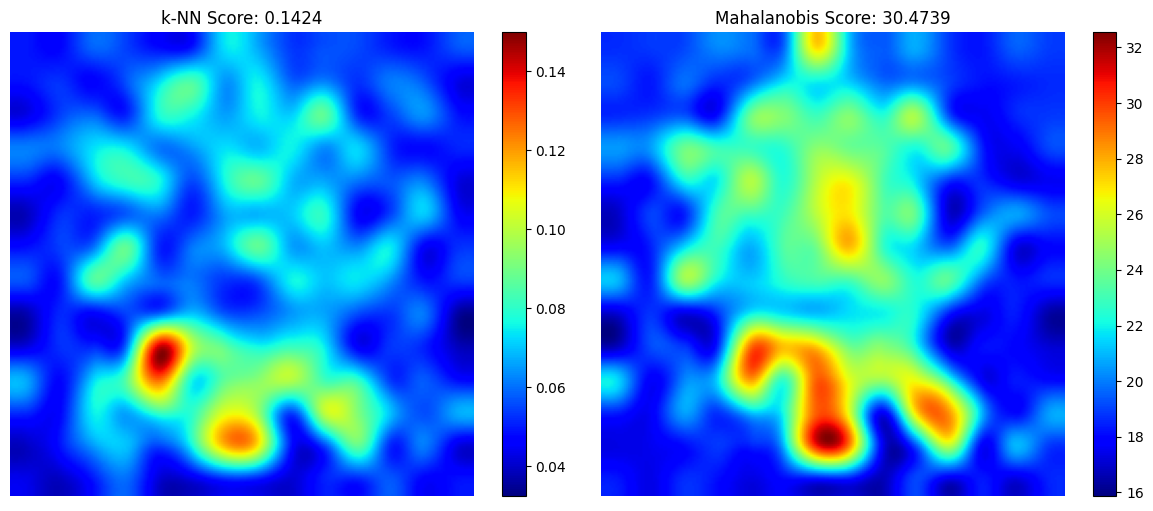

In [ ]:
# Compare different scoring methods
# Create Mahalanobis scorer
scorer_mahal = AnomalyScorer(
    feature_bank=detector.feature_bank,
    patch_grid_size=detector.feature_extractor.get_patch_grid_size(224),
    method='mahalanobis'
)
scorer_mahal.threshold = 3.0  # Typical threshold for Mahalanobis

# Test same image with both methods
image_tensor = detector.preprocessor.preprocess_single(test_image)
patch_features = detector.feature_extractor.extract_features(image_tensor)[0].cpu().numpy()

result_knn = detector.scorer.score_image(patch_features, target_size=(224, 224))
result_mahal = scorer_mahal.score_image(patch_features, target_size=(224, 224))

print(f"k-NN Score: {result_knn.image_score:.4f}")
print(f"Mahalanobis Score: {result_mahal.image_score:.4f}")

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(result_knn.anomaly_map, cmap='jet')
axes[0].set_title(f"k-NN Score: {result_knn.image_score:.4f}")
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(result_mahal.anomaly_map, cmap='jet')
axes[1].set_title(f"Mahalanobis Score: {result_mahal.image_score:.4f}")
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()